In [8]:
# # to find the directory you're in ,
# !ls
# #if you wanna go into a folder (say samplefolder)
# %cd /content/drive/My Drive 

drive  sample_data
/content/drive/My Drive


In [9]:
# import os
# os.getcwd()

'/content/drive/My Drive'

In [10]:
# !unzip whole.zip -d whole

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: whole/x-ray/fracture_resize_reverse/241l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1061r.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/111r.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1124r.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1331l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/392r.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/238r.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/187l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/168l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/492l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1348r.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1262l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/257l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1327l.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1098r.jpg  
  inflating: whole/x-ray/fracture_resize_reverse/1132r.jp

In [17]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt
from matplotlib.image import imread

import sys
import glob

import numpy as np

Using TensorFlow backend.


In [0]:
# /content/drive/My Drive/whole/x-ray/Normal_resize_reverse_crop
# /content/drive/My Drive/whole/x-ray/fracture_resize_reverse_crop

In [0]:
path_normal ='/content/drive/My Drive/whole/x-ray/Normal_resize_reverse_crop'
path_fracture = '/content/drive/My Drive/whole/x-ray/fracture_resize_reverse_crop'

In [0]:
# class_ = {'normal', 'fracture'}

In [41]:
normal_image_path_names = []
fracture_image_path_names = []
class_names=set()

# Get Images in folders
for file_n in glob.glob(path_normal + '/*.jpg'):
  normal_image_path_names.append(file_n)
  class_names.add(file_n.split('/')[-2].split('_')[0])

for file_f in glob.glob(path_fracture + '/*.jpg'):
  fracture_image_path_names.append(file_f)
  class_names.add(file_f.split('/')[-2].split('_')[0])

print('class_name: ', class_names) #{'fracture', 'Normal'}

class_name:  {'fracture', 'Normal'}


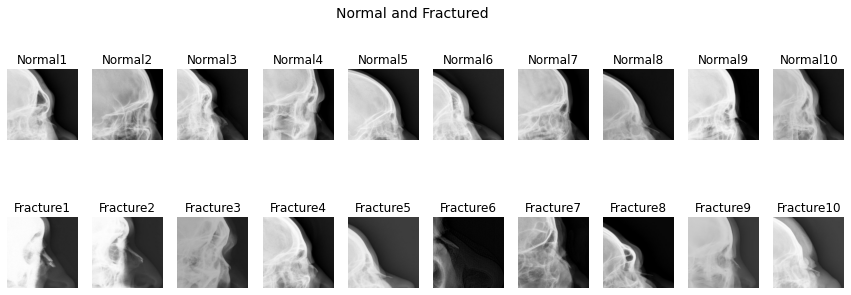

In [52]:
# Check if training data looks all right
import random

fig, axs = plt.subplots(2, 10, figsize=(15, 5))
for i in range(10) :
  img_normal = imread(normal_image_path_names[i])
  img_fracture = imread(fracture_image_path_names[i])
  fig.suptitle('Normal and Fractured', fontsize=14)
  axs[0, i].set_axis_off()
  axs[0, i].set_title('Normal{}'.format(i+1))
  axs[0, i].imshow(img_normal, cmap='gray')
  axs[1, i].set_axis_off()
  axs[1, i].set_title('Fracture{}'.format(i+1))
  axs[1, i].imshow(img_fracture, cmap='gray')

In [53]:
print(len(normal_image_path_names))
print(len(fracture_image_path_names))

693
1127


In [46]:
print(img_normal.shape)
print(img_fracture.shape)

(224, 224, 3)
(224, 224, 3)


In [0]:
def vgg(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
  inputs = Input(input_size)
  # s = Lambda(lambda x: x / 255) (inputs)
  z1 = ZeroPadding2D((1, 1), input_shape=(224, 224, 3))(inputs)
  c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z1)
  z1 = ZeroPadding2D((1,1))(c1)
  c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z1)
  
  p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)

  z2 = ZeroPadding2D((1,1))(p1)
  c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z2)
  z2 = ZeroPadding2D((1,1))(c2)
  c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z2)

  p2 = MaxPooling2D((2,2), strides=(2,2))(c2)

  z3 = ZeroPadding2D((1,1))(p2)
  c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z3)
  z3 = ZeroPadding2D((1,1))(c3)
  c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z3)
  z3 = ZeroPadding2D((1,1))(c3)
  c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z3)

  p3 = MaxPooling2D((2,2), strides=(2,2))(c3)

  z4 = ZeroPadding2D((1,1))(p3)
  c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z4)
  z4 = ZeroPadding2D((1,1))(c4)
  c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z4)
  z4 = ZeroPadding2D((1,1))(c4)
  c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z4)

  p4 = MaxPooling2D((2,2), strides=(2,2))(c4)

  z5 = ZeroPadding2D((1,1))(p4)
  c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z5)
  z5 = ZeroPadding2D((1,1))(c5)
  c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z5)
  z5 = ZeroPadding2D((1,1))(c5)
  c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(z5)

  p5 = MaxPooling2D((2,2), strides=(2,2))(c5)

  c6 = Conv2D(4096, (7,7), activation = 'relu')(p5)
  c6 = Dropout(0.5)(c6)
  c6 = Conv2D(4096, (1, 1), activation = 'relu')(c6)
  c6 = Dropout(0.5)(c6)
  c6 = Conv2D(2622, (1, 1))(c6)

  c7 = Flatten()(c6)

  ouputs = Softmax()(c7)

  return Model(inputs=[inputs], outpusts=[outputs])

In [0]:
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 
 
 
 
# data_list = glob('blood-cells/dataset2-master/images/TRAIN/**/*.jpeg')
# print(data_list[-1])
 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_dir = os.path.join('./dataset/1/images/train')
val_dir = os.path.join('./dataset/1/images/val')
test_dir = os.path.join('./dataset/1/images/test')
 
# train_dir = os.path.join('./dataset/cats_and_dogs_small/train')
# val_dir = os.path.join('./dataset/cats_and_dogs_small/val')
# test_dir = os.path.join('./dataset/cats_and_dogs_small/test')
 
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(220, 200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(220, 200), color_mode='rgb')
 
 
 
input_tensor = Input(shape=(220, 200, 3), dtype='float32', name='input')
 
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer='he_normal')(x)
x = layers.Dense(2048, kernel_initializer='he_normal')(x)
x = layers.Dense(1024, kernel_initializer='he_normal')(x)
output_tensor = layers.Dense(4, activation='softmax')(x)
 
myvgg = Model(input_tensor, output_tensor)
myvgg.summary()
 
 
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='My_VGG_weight.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)
 
myvgg.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])
 
 
history = myvgg.fit_generator(train_generator, 
            steps_per_epoch=25, 
            epochs=300, 
            validation_data=val_generator, 
            validation_steps=16, 
            callbacks=[checkpoint])
 
 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()
